In [2]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use("seaborn")

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Fetch the ethin dataset & Network

In [3]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset

dim = 38

S, P = np.load("../ethin/dataset_ethin_6-31g**.npy")
molecules = np.load("../ethin/molecules_ethin_6-31g**.npy")
dataset, molecules = make_butadien_dataset(molecules, S.reshape(-1, dim, dim), P.reshape(-1, dim, dim))

[-] 2018-06-10 12:32:20: Data set normalized. Mean value std: 0.02775708963766184


In [4]:
from SCFInitialGuess.nn.networks import EluFixedValue

graph = tf.Graph()

structure, weights, biases = np.load("../ethin/network_ethin.npy", encoding="latin1")

with graph.as_default():
    sess = tf.Session()
    network = EluFixedValue(structure, weights, biases)
    network.setup()
    sess.run(tf.global_variables_initializer())

In [5]:
from SCFInitialGuess.utilities.dataset import extract_triu
s_normed_triu = np.array(list(map(lambda x: extract_triu(x, dim), dataset.testing[0])))

# calculate the guesses 

In [6]:
from pyscf.scf import hf
from SCFInitialGuess.utilities.dataset import make_matrix_batch
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

p_nn = network.run(sess, s_normed_triu)

p_batch = make_matrix_batch(p_nn, dim, True)
p_mcw1 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=1), zip(p_batch, dataset.testing[0]))))
p_mcw5 = np.array(list(map(lambda x: multi_mc_wheeny(x[0], x[1], n_max=5), zip(p_batch, dataset.testing[0]))))

p_sap = np.array([
    hf.init_guess_by_atom(mol.get_pyscf_molecule()) for mol in molecules[1]
])
p_minao = np.array([
    hf.init_guess_by_minao(mol.get_pyscf_molecule()) for mol in molecules[1]
])
p_gwh = np.array([
    hf.init_guess_by_wolfsberg_helmholtz(mol.get_pyscf_molecule()) for mol in molecules[1]
])

# create the plot


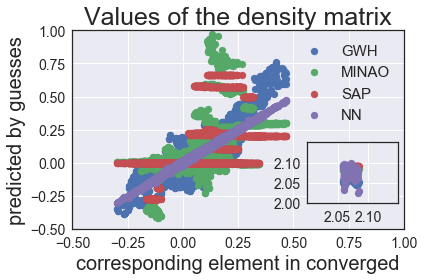

In [54]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

expected = dataset.testing[1].flatten()
upper = 1
lower = -.5


#--- outer ---
fig, ax = plt.subplots()
plt.scatter(expected, p_gwh.flatten(), label="GWH")
plt.scatter(expected, p_minao.flatten(), label="MINAO")
plt.scatter(expected, p_sap.flatten(), label="SAP")
plt.scatter(expected, p_batch.flatten(), label="NN")

plt.title("Values of the density matrix", fontsize=25)
plt.ylabel("predicted by guesses", fontsize=20)
plt.xlabel("corresponding element in converged", fontsize=20)
plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.legend(fontsize=15)
plt.tick_params(labelsize=14)
plt.tight_layout()
#---

#--- insert ---
lower, upper = 2.0, 2.15
#ax_inner = inset_axes(ax, width="20%", height="25%", loc=7)
ax_inner = plt.axes([0.72, 0.28, 0.21, 0.21])
ax_inner.scatter(expected, p_gwh.flatten(), label="GWH")
ax_inner.scatter(expected, p_minao.flatten(), label="MINAO")
ax_inner.scatter(expected, p_sap.flatten(), label="SAP")
ax_inner.scatter(expected, p_batch.flatten(), label="NN")

plt.xlim(lower, upper)
plt.ylim(lower, upper)
plt.xticks([2.05, 2.1])
plt.yticks([2.0,2.05, 2.1])
plt.tick_params(labelsize=14)

#plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"] = 1.25
#plt.tight_layout()
#---
plt.savefig("/home/jo/Repos/cc2aiPoster/figures/EthinPredictionScatter.png")
plt.show()

In [28]:
p_batch.flatten().shape

(72200,)